# Loading Dataset and Merging

In [3]:
import pandas as pd
import re
import os

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\63936\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\63936\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
dataset_path = '../dataset'

dataframes = []

for filename in os.listdir(dataset_path):
    if filename.endswith('.csv'):
        
        file_path = os.path.join(dataset_path, filename)
       
        parts = filename.split('_')
        subreddit_name = parts[1]
        search_input = parts[2]
        
        df = pd.read_csv(file_path, parse_dates=['created'], dtype={
            'title': 'string', 'body': 'string', 'link': 'string', 
            'author': 'string', 'upvotes': 'int64'
        })
        
        df['subreddit'] = subreddit_name
        df['search_input'] = search_input
        
        if not df.empty and not df.isna().all().all():
            dataframes.append(df)

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    print("No valid CSV files found or all files are empty.")

In [5]:
combined_df.head()

,title,body,link,author,created,upvotes,num_comments,subreddit,search_input
0,"""Child Abuse""",Intro: Hi 🖐️ I'm a new user of this Reddit app...,https://www.reddit.com/r/alasjuicy/comments/1b...,t2_ws92bksht,2024-04-08 15:27:57,0,4,alasjuicy,abused
1,The Auditory Pleasure of Being Used and Abused,*Long read.* Sit tight and strap in. You’d th...,https://www.reddit.com/r/alasjuicy/comments/yv...,t2_snjvptth,2022-11-15 16:46:41,30,10,alasjuicy,abused
2,why do people tolerate this kind of abuse?,There are always so many posts involving inces...,https://www.reddit.com/r/alasjuicy/comments/uj...,t2_4lv0em6g,2022-05-06 13:34:41,138,63,alasjuicy,abused
3,Her mom thought I'm abusing her,"The other other day, Me and my partner got rea...",https://www.reddit.com/r/alasjuicy/comments/1a...,t2_uk1z6h3f,2024-01-28 03:23:23,26,3,alasjuicy,abused
4,Saw my abuser today and had to pretend I didn’...,I was molested from time to time from the age...,https://www.reddit.com/r/alasjuicy/comments/10...,t2_5xg4fclu,2023-01-30 23:53:34,206,41,alasjuicy,abused


In [6]:
combined_df.shape

(1921, 9)

In [7]:
combined_df.describe()

,created,upvotes,num_comments
count,1921,1921.000000,1921.000000
mean,2022-07-19 09:35:59.136908032,70.358147,27.482041
min,2013-08-07 01:22:56,0.000000,0.000000
25%,2022-01-01 09:27:02,2.000000,2.000000
50%,2023-04-19 11:03:04,8.000000,7.000000
75%,2023-11-25 23:58:54,37.000000,23.000000
max,2024-04-17 09:44:55,4945.000000,1440.000000
std,NaN,243.546844,78.961560


In [8]:
combined_df.count()

title           1921
body            1731
link            1921
author          1921
created         1921
upvotes         1921
num_comments    1921
subreddit       1921
search_input    1921
dtype: int64

In [9]:
combined_df['subreddit'].unique()

array(['alasjuicy', 'MentalHealthPH', 'OffmychestPH', 'Philippines',
       'relationship advicePH'], dtype=object)

In [10]:
combined_df['search_input'].unique()

array(['abused', 'Cyberbullying', 'domestic violence', 'emotional abuse',
       'physical abuse', 'sexual harassment', 'stalking',
       'unsolicited pics'], dtype=object)

# Pre-processing Steps

In [50]:
combined_df.isnull().sum()

title                 0
body                  0
link                  0
author                0
created               0
upvotes               0
num_comments          0
subreddit             0
search_input          0
age_gender            0
year                  0
month                 0
day                   0
post_length           0
day_of_week           0
is_weekend            0
time_of_day           0
upvotes_relative      0
subreddit_size        0
upvotes_per_capita    0
body_text             0
relationship          0
dtype: int64

In [51]:
combined_df.dropna(subset=['body'], inplace=True)

In [52]:
def find_age_gender(text):
    matches = re.findall(r'\b(\d{2}\s?[MF])\b', text.upper())
    return matches

combined_df['age_gender'] = combined_df['body'].apply(find_age_gender)

AttributeError: 'list' object has no attribute 'upper'

In [ ]:
def remove_mentions_and_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    subreddit_pattern = r'\br/\w+'

    
    text = re.sub(url_pattern, '', text)
    text = re.sub(subreddit_pattern, '', text)
    text = re.sub(r'\[([^\]]+)\]\(\)', r'\1', text)

    return text

combined_df['body'] = combined_df['body'].apply(remove_mentions_and_urls)

In [ ]:
# text tokenization and stop words removal
import advertools as adv

stop_words = set(stopwords.words('english')).union(set(adv.stopwords['tagalog']))
print(stop_words)

def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

{'other', 'paano', 'and', 'not', 'kanila', 'shan', 'will', 'nagkaroon', 'aking', 'so', 'here', 'kanyang', 'now', 'before', 'y', 'where', 'lima', 'ginawang', 'for', 'aming', "you're", 'how', 'bawat', 'laban', 'katiyakan', 'their', "she's", 'maaaring', 'mayroon', 'bilang', 'wouldn', 'maging', 'pataas', 'amin', 'with', 'ginagawa', 'own', 'this', 'while', 'nila', 'may', 'in', 'ngayon', "couldn't", 'to', 'bago', 'couldn', 'kapag', 'have', 'himself', 'ma', 'won', 'dalawa', 'ng', 'needn', 'kumuha', 'isn', 'from', 'out', 'ilagay', 'kailangan', 'me', 'hasn', 'be', 'after', 'did', 'nabanggit', 'over', 'ginawa', 'of', 'myself', 'tungkol', 'makita', "you've", 'itaas', 'sila', 'most', 'yourself', 'no', 'maaari', 'll', 'hers', 'being', 'katulad', "didn't", 'am', 'any', 'kahit', 'both', 'noon', 'minsan', 'or', 'don', "you'd", "it's", 'them', "weren't", 'masyado', "mightn't", 'he', 'm', "you'll", 'having', 'narito', 'through', 'atin', 'is', 'd', 'pamamagitan', 'lamang', 'siya', 'isang', 'pa', 'again',

In [ ]:
combined_df['title'] = combined_df['title'].apply(tokenize_and_remove_stopwords)
combined_df['body'] = combined_df['body'].apply(tokenize_and_remove_stopwords)

TypeError: expected string or bytes-like object

In [ ]:
# feature engineering

# extract year, month, day from the 'created' column
combined_df['year'] = combined_df['created'].dt.year
combined_df['month'] = combined_df['created'].dt.month
combined_df['day'] = combined_df['created'].dt.day

In [ ]:
# calculate post length
combined_df['post_length'] = combined_df['body'].apply(len)

In [ ]:
# calculate day of the week and other time-related features
combined_df['day_of_week'] = combined_df['created'].dt.dayofweek
combined_df['is_weekend'] = combined_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
combined_df['time_of_day'] = pd.cut(combined_df['created'].dt.hour, 
                                   bins=[0, 6, 12, 18, 24], 
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                                   right=False)

In [ ]:
# relative_upvotes
# normalize upvotes by the average upvotes per month to see if certain posts got unusually high engagement
monthly_avg_upvotes = combined_df.groupby('month')['upvotes'].transform('mean')
combined_df['upvotes_relative'] = combined_df['upvotes'] / monthly_avg_upvotes

In [ ]:
membership_sizes = {
    'alasjuicy': 247000,
    'OffmychestPH': 493000,
    'relationship advicePH': 130000,
    'MentalHealthPH': 46000,
    'Philippines': 1700000
}

combined_df['subreddit_size'] = combined_df['subreddit'].map(membership_sizes)

In [ ]:
combined_df['upvotes_per_capita'] = combined_df['upvotes'] / combined_df['subreddit_size']

In [ ]:
combined_df['age_gender']

0               []
1               []
2               []
3               []
4               []
           ...    
1916            []
1917         [24F]
1918            []
1919    [22F, 23M]
1920            []
Name: age_gender, Length: 1731, dtype: object

# PH Holidays

In [53]:
data = {
    'Date': ['01-01', '03-28', '03-29', '04-09', '05-01', '06-12', '08-26', '11-30', '12-25', '12-30', 
             '04-10', '08-21', '11-01', '12-08', '12-31', '02-09', '02-10', '03-30', '11-02', '12-24', '03-01'],
    'Holiday': ['New Year\'s Day', 'Maundy Thursday', 'Good Friday', 'Araw ng Kagitingan', 'Labor Day', 
                'Independence Day', 'National Heroes Day', 'Bonifacio Day', 'Christmas Day', 'Rizal Day', 
                'Eid\'l Fitr', 'Ninoy Aquino Day', 'All Saints\' Day', 'Feast of the Immaculate Conception of Mary', 
                'Last Day of the Year', 'Additional Special (Non-Working) Day', 'Chinese New Year', 'Black Saturday', 
                'All Souls\' Day', 'Christmas Eve', 'Women\'s Month Start'],
    'Type': ['Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 
             'Regular', 'Regular', 'Special Non-Working', 'Special Non-Working', 'Special Non-Working', 
             'Special Non-Working', 'Special Non-Working', 'Special Non-Working', 'Special Non-Working', 
             'Special Non-Working', 'Special Non-Working', 'Special Non-Working']
}

holidays_df = pd.DataFrame(data)

holidays_df


,Date,Holiday,Type
0,01-01,New Year's Day,Regular
1,03-28,Maundy Thursday,Regular
2,03-29,Good Friday,Regular
3,04-09,Araw ng Kagitingan,Regular
4,05-01,Labor Day,Regular
5,06-12,Independence Day,Regular
6,08-26,National Heroes Day,Regular
7,11-30,Bonifacio Day,Regular
8,12-25,Christmas Day,Regular
9,12-30,Rizal Day,Regular


In [54]:
holidays_df.to_csv('ph_holidays.csv', index=False)

# Extracting relationship from text

In [55]:
import subprocess
import sys

def install_packages():
    subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])

    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    
except OSError:
    install_packages()
    import spacy
    nlp = spacy.load("en_core_web_sm")

In [56]:
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [57]:
relationship_patterns = {
    'family': [
        [{"LOWER": word}] for word in ['mother', 'father', 'sister', 'brother', 'sibling', 'nanay', 'tatay', 'kuya', 'ate', 'kapatid', 
                                       'lola', 'lolo', 'grandmother', 'grandfather', 'cousin', 'pinsan', 'tito', 'tita', 'uncle', 'aunt']
    ],
    'partner': [
        [{"LOWER": word}] for word in ['husband', 'wife', 'boyfriend', 'girlfriend', 'bf', 'gf', 'asawa', 'jowa', 'so', 'partner', 
                                       'spouse', 'misis', 'mister', 'fiance', 'fiancee', 'kasintahan', 'syota', 'live-in', 'livein']
    ],
    'classmate': [
        [{"LOWER": word}] for word in ['classmate', 'kaklase', 'schoolmate', 'seatmate', 'batchmate', 'school friend']
    ],
    'acquaintance': [
        [{"LOWER": word}] for word in ['friend', 'neighbor', 'colleague', 'workmate', 'kaibigan', 'kapitbahay', 'kasamahan', 'boss', 
                                       'supervisor', 'manager', 'co-worker', 'barkada', 'comrade', 'kabarkada', 'amigo', 'amiga']
    ],
    'stranger': [
        [{"LOWER": word}] for word in ['stranger', 'unknown person', 'di kilala', 'unknown', 'outsider', 'foreigner', 'bystander']
    ]
}

In [58]:
for label, patterns in relationship_patterns.items():
    matcher.add(label, patterns)

def extract_relationship(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    if matches:
        match_id, start, end = max(matches, key=lambda x: x[1]-x[2])
        return nlp.vocab.strings[match_id]
    return 'unknown'

In [59]:
combined_df['body_text'] = combined_df['body'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
combined_df['relationship'] = combined_df['body_text'].apply(extract_relationship)
combined_df

,title,body,link,author,created,upvotes,num_comments,subreddit,search_input,age_gender,...,day,post_length,day_of_week,is_weekend,time_of_day,upvotes_relative,subreddit_size,upvotes_per_capita,body_text,relationship
0,"[``, Child, Abuse, '']","[Intro, :, Hi, 🖐️, I, 'm, new, user, Reddit, a...",https://www.reddit.com/r/alasjuicy/comments/1b...,t2_ws92bksht,2024-04-08 15:27:57,0,4,alasjuicy,abused,[],...,8,919,0,0,Afternoon,0.000000,247000,0.000000,Intro : Hi 🖐️ I 'm new user Reddit app . Recen...,partner
1,"[The, Auditory, Pleasure, Being, Used, Abused]","[*, Long, read, ., *, Sit, tight, strap, ., Yo...",https://www.reddit.com/r/alasjuicy/comments/yv...,t2_snjvptth,2022-11-15 16:46:41,30,10,alasjuicy,abused,[],...,15,1920,1,0,Afternoon,0.367653,247000,0.000121,* Long read . * Sit tight strap . You ’ think ...,stranger
2,"[people, tolerate, kind, abuse, ?]","[There, always, many, posts, involving, incest...",https://www.reddit.com/r/alasjuicy/comments/uj...,t2_4lv0em6g,2022-05-06 13:34:41,138,63,alasjuicy,abused,[],...,6,269,4,0,Afternoon,2.458475,247000,0.000559,There always many posts involving incest espec...,unknown
3,"[Her, mom, thought, I, 'm, abusing]","[The, day, ,, Me, partner, got, really, spicy,...",https://www.reddit.com/r/alasjuicy/comments/1a...,t2_uk1z6h3f,2024-01-28 03:23:23,26,3,alasjuicy,abused,[],...,28,96,6,1,Night,0.504762,247000,0.000105,"The day , Me partner got really spicy usually ...",partner
4,"[Saw, abuser, today, pretend, I, ’, remember, .]","[I, molested, time, time, age, 7, years, old, ...",https://www.reddit.com/r/alasjuicy/comments/10...,t2_5xg4fclu,2023-01-30 23:53:34,206,41,alasjuicy,abused,[],...,30,144,0,0,Evening,3.999267,247000,0.000834,I molested time time age 7 years old ( I think...,family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,"[6, years, dating, stage, ,, [, F20, ], [, M21...","[*, *, TL, ;, DR, I, still, feelings, despite,...",https://www.reddit.com/r/relationship_advicePH...,t2_aiqjw9xzg,2023-05-03 23:45:07,2,11,relationship advicePH,stalking,[],...,3,494,2,0,Evening,0.035630,130000,0.000015,* * TL ; DR I still feelings despite us toxic ...,unknown
1917,"[[, F24, ], relationship, (, M35, ), ., We, to...","[im, 24F, ., independent, since, 16., ex, bf, ...",https://www.reddit.com/r/relationship_advicePH...,t2_7q6qsclb,2023-08-15 13:47:01,1,0,relationship advicePH,stalking,[24F],...,15,560,1,0,Afternoon,0.016638,130000,0.000008,im 24F . independent since 16. ex bf 3 yrs man...,partner
1918,"[I, [, 19M, ], found, boyfriend, [, 19M, ], us...","[I, 'm, gay, ive, boyfriend, nang, mahigit, ta...",https://www.reddit.com/r/relationship_advicePH...,t2_mxfkv6gd,2023-05-26 20:29:36,3,3,relationship advicePH,stalking,[],...,26,561,4,0,Evening,0.053445,130000,0.000023,I 'm gay ive boyfriend nang mahigit taon . Eve...,partner
1919,"[Bf, likes, get, using, *, l, *, gram, n, *, d...","[I, (, 22F, ), bf, (, 23M, ), together, almost...",https://www.reddit.com/r/relationship_advicePH...,t2_jrq6uq3vw,2023-09-16 11:05:19,27,30,relationship advicePH,unsolicited pics,"[22F, 23M]",...,16,138,5,1,Morning,0.276330,130000,0.000208,I ( 22F ) bf ( 23M ) together almost 5 years ....,partner


In [60]:
combined_df.to_csv('preprocessed_dataset.csv', index=False)

# Load Preprocessed Dataset CSV

In [9]:
combined_df = pd.read_csv('preprocessed_dataset.csv')
combined_df['body_text'] = combined_df['body'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
combined_df


,title,body,link,author,created,upvotes,num_comments,subreddit,search_input,age_gender,...,day,post_length,day_of_week,is_weekend,time_of_day,upvotes_relative,subreddit_size,upvotes_per_capita,body_text,relationship
0,"['I', ""n't"", 'care', ""'re"", 'girl', ',', 'unso...","['So', 'like', 'many', 'people', 'subreddit', ...",https://www.reddit.com/r/alasjuicy/comments/10...,t2_uzp1eor9,2023-01-10 18:35:34,126,20,alasjuicy,unsolicited pics,[],...,10,139,1,0,Evening,2.446154,247000,0.000510,"['So', 'like', 'many', 'people', 'subreddit', ...",partner
1,"['Unsolicited', 'Dick', 'Pics', 'Enjoyer']","['Bago', 'lang', 'ako', 'naging', 'active', 'd...",https://www.reddit.com/r/alasjuicy/comments/1a...,t2_9x1nt0ze2,2024-02-08 03:58:45,68,54,alasjuicy,unsolicited pics,[],...,8,125,3,0,Night,0.961844,247000,0.000275,"['Bago', 'lang', 'ako', 'naging', 'active', 'd...",unknown
2,"['UNSOLICITED', 'DICK', 'PIC']","['Hello', 'men', 'aj', '!', 'Eto', 'sakin', 'l...",https://www.reddit.com/r/alasjuicy/comments/18...,t2_q6lir5af,2023-11-27 19:50:18,84,59,alasjuicy,unsolicited pics,[],...,27,146,0,0,Evening,1.029428,247000,0.000340,"['Hello', 'men', 'aj', '!', 'Eto', 'sakin', 'l...",unknown
3,"['Unsolicited', '!', 'ck', 'pics']","['really', 'irks', 'knowing', 'na', 'ang', 'da...",https://www.reddit.com/r/alasjuicy/comments/1c...,t2_ssss4d1u,2024-04-16 23:39:01,17,36,alasjuicy,unsolicited pics,[],...,16,72,1,0,Evening,0.319948,247000,0.000069,"['really', 'irks', 'knowing', 'na', 'ang', 'da...",unknown
4,"['Kelan', 'ba', 'titigil', 'unsolicited', 'dic...","['Pakiusap', 'naman', ',', 'di', 'porket', 'na...",https://www.reddit.com/r/alasjuicy/comments/1b...,t2_xb6pbdoh7,2024-04-03 18:35:41,45,46,alasjuicy,unsolicited pics,[],...,3,43,2,0,Evening,0.846920,247000,0.000182,"['Pakiusap', 'naman', ',', 'di', 'porket', 'na...",unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,"['How', 'I', 'deal', 'friend', ""'s"", 'currentl...","['TW', ':', 'mentions', 's\\', '*', 'icidal', ...",https://www.reddit.com/r/OffMyChestPH/comments...,t2_un04y83t,2022-11-29 14:24:57,2,0,OffmychestPH,sexual harassment,[],...,29,473,1,0,Afternoon,0.024510,493000,0.000004,"['TW', ':', 'mentions', 's\\', '*', 'icidal', ...",acquaintance
1727,"['It', ""'s"", 'difficult', 'recover', 'addictio...","['Trigger', 'Warning', '.', 'I', ""'ve"", 'hyper...",https://www.reddit.com/r/OffMyChestPH/comments...,t2_935kirllt,2023-04-19 11:03:04,1,0,OffmychestPH,sexual harassment,[],...,19,422,2,0,Morning,0.018820,493000,0.000002,"['Trigger', 'Warning', '.', 'I', ""'ve"", 'hyper...",unknown
1728,"['I', 'fix', '/s']","['Hello', 'mga', 'ka-', ',', 'first', 'reddit'...",https://www.reddit.com/r/OffMyChestPH/comments...,t2_8qrq5cgm,2024-02-23 07:43:34,20,2,OffmychestPH,sexual harassment,[],...,23,535,4,0,Morning,0.282895,493000,0.000041,"['Hello', 'mga', 'ka-', ',', 'first', 'reddit'...",acquaintance
1729,"['Enduring', 'harsh', 'life']","['I', ""'ve"", 'always', 'suicidal', ',', 'since...",https://www.reddit.com/r/OffMyChestPH/comments...,t2_v9r39810t,2024-03-15 16:47:35,0,2,OffmychestPH,sexual harassment,[],...,15,755,4,0,Afternoon,0.000000,493000,0.000000,"['I', ""'ve"", 'always', 'suicidal', ',', 'since...",family


# [Relationships] Train model and evaluate

In [64]:
encoder = OneHotEncoder()
relationship_encoded = encoder.fit_transform(combined_df[['relationship']])

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
text_features = tfidf_vectorizer.fit_transform(combined_df['body_text'])

from scipy.sparse import hstack
X = hstack([text_features, relationship_encoded])

y = combined_df['search_input']


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.46153846153846156
Classification Report:
                    precision    recall  f1-score   support

    Cyberbullying       0.39      0.58      0.47        12
           abused       0.51      0.26      0.35       117
domestic violence       0.47      0.32      0.38        25
  emotional abuse       0.34      0.38      0.36        96
   physical abuse       0.31      0.36      0.33       104
sexual harassment       0.49      0.58      0.53        50
         stalking       0.63      0.80      0.71       100
 unsolicited pics       0.80      0.75      0.77        16

         accuracy                           0.46       520
        macro avg       0.49      0.50      0.49       520
     weighted avg       0.47      0.46      0.45       520



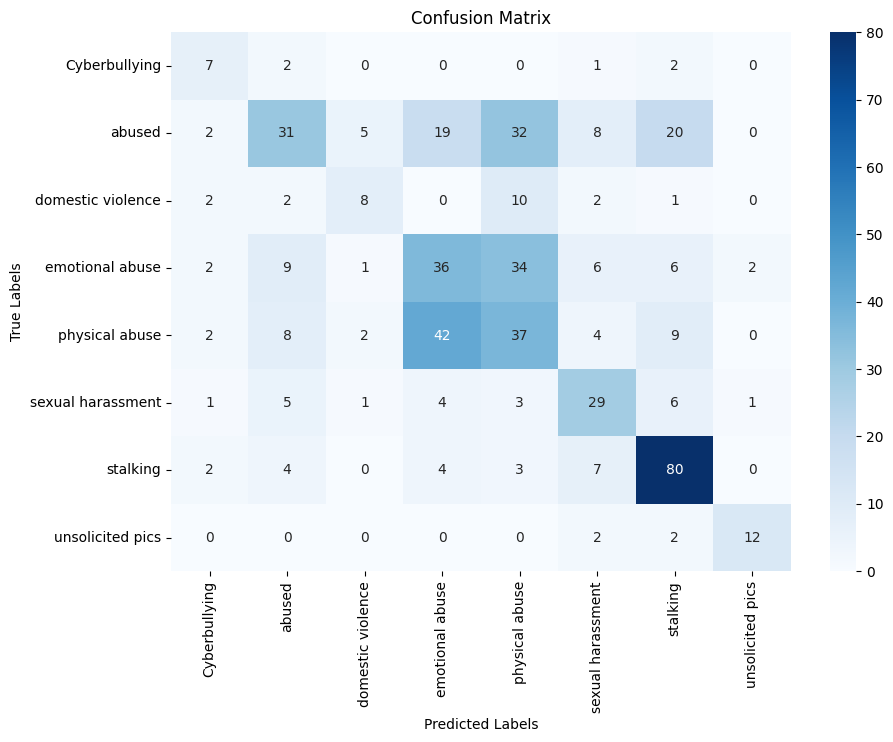

In [66]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
